<a href="https://colab.research.google.com/github/OgunSerifOnargan/arkitek_notebooks/blob/main/videoMAE_performanceEvaluatoripynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTEBOOK PREP

In [ ]:
!pip install -q pytorchvideo transformers evaluate
!pip install transformers[torch]
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:0

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import imageio
import numpy as np
from IPython.display import Image
import torch
import shutil
import os
from tqdm import tqdm
import cv2
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
import pytorchvideo.data

In [ ]:
def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 1}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)


def run_inference(model, avideo):
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = avideo["video"].permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [avideo["label"]]
        ),  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

# DATA PREP

In [ ]:
# @title
#output folder creation
def videomae_folder_order_creator(output_folder_path, class_names):
  shutil.rmtree(output_folder_path, ignore_errors=True)
  for folder in ["train","val","test"]:
    for class_name in class_names:
      class_folder_path = output_folder_path + "/" + folder + "/" + class_name
      os.makedirs(class_folder_path, exist_ok=True)

def excel_train_val_test_splitter(df_excel, division_ratios):
  len_train = int(len(df_excel)*division_ratios[0])
  len_val = int(len(df_excel)*division_ratios[1])
  len_test = int(len(df_excel)*division_ratios[2])

  train_df = df_excel[:len_train]
  val_df = df_excel[len_train : (len_train+len_val)]
  test_df = df_excel[(len_train+len_val):]

  return train_df, val_df, test_df


def process_avideo(video_path, label, frame_interval, output_folder_path, folder):

  max_frame, min_frame = frame_interval

  cap = cv2.VideoCapture(video_path)

  new_videos_df = pd.DataFrame(columns=["video_name", "num_frames", "label"])
  frames = []
  try:
      frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      fps = cap.get(cv2.CAP_PROP_FPS)
      while True:
          ret, frame = cap.read()
          if not ret:
              break
          frames.append(frame)
  finally:
      cap.release()

  video_index = 0
  while frames:
      video_name = video_path.split("/")[-1].split(".")[-2]
      new_video_path = f"{output_folder_path}/{folder}/{label}/{video_name}_{video_index}.mp4"

      new_video_frames = frames[:max_frame]
      frames = frames[max_frame:]
      frame_shape = new_video_frames[0].shape[:2][::-1]

      out = cv2.VideoWriter(new_video_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, frame_shape)

      if len(new_video_frames) >= min_frame:
        for frame in new_video_frames:
            out.write(frame)
        out.release()

        new_video_name = new_video_path.split("/")[-1]
        new_row = {"video_name":new_video_name, "num_frames":len(new_video_frames) ,"label":label}
        new_videos_df = new_videos_df.append(new_row, ignore_index=True)

        video_index += 1
      else:
        break
  return new_videos_df


def control_folder_size(path):

  files = os.listdir(path)

  # Count the number of files
  num_files = len(files)

  print(f"Number of files in the folder: {num_files}")


In [ ]:
# @title
def main_data_prep(root_video_folder_path, excel_file_path, output_folder_path, division_ratios, class_names, frame_interval, balanced=False):
  #read excel file from original path
  df_excel = pd.read_excel(excel_file_path, header=None)

  #manipulate labels according to class names
  df_excel[2] = df_excel[2].replace({i : class_names[i] for i in df_excel[2].unique()})
  classes = df_excel[2].unique()

  #output folder creation
  videomae_folder_order_creator(output_folder_path, class_names)
  df_excel = df_excel.sample(frac=1, random_state=42).reset_index(drop=True)
  #dividing data and convert it to df
  train_df, val_df, test_df = excel_train_val_test_splitter(df_excel, division_ratios)

  df_list = [train_df, val_df, test_df]
  df_names = ["train", "val", "test"]

  process_counter_main = 0
  for i, df in enumerate(df_list):
    df_name = df_names[i]
    final_df = pd.DataFrame(columns=["video_name", "num_frames", "label"])

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing videos"):
      video_path = root_video_folder_path + "/" + row[0] + ".mp4"
      label = row[2]

      new_videos_df = process_avideo(video_path, label, frame_interval, output_folder_path, df_name)

      final_df = pd.concat([final_df, new_videos_df], ignore_index=True)

    final_df.to_excel(f"{output_folder_path}/{df_name}.xlsx", index=False)

  if balanced == True:
    train_df_new_path = f"{output_folder_path}/train.xlsx"
    train_df_new = pd.read_excel(train_df_new_path, header=None)
    train_df_new = train_df_new.drop(0)
    train_df_new = train_df_new.reset_index(drop=True)
    tag_0_rows = train_df_new[train_df_new[2] == classes[0]]
    tag_1_rows = train_df_new[train_df_new[2] == classes[1]]

    num_samples_0 = len(tag_0_rows)
    num_samples_1 = len(tag_1_rows)

    if num_samples_1 < num_samples_0:
      balanced_tag_0_rows = tag_0_rows.sample(n=num_samples_1, random_state=42)
      balanced_df = pd.concat([balanced_tag_0_rows, tag_1_rows], ignore_index=True)
    if num_samples_1 > num_samples_0:
      balanced_tag_1_rows = tag_1_rows.sample(n=num_samples_0, random_state=42)
      balanced_df = pd.concat([balanced_tag_1_rows, tag_0_rows], ignore_index=True)

    train_df_last = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    video_folder = f"{output_folder_path}/train"

    for root, dirs, files in os.walk(video_folder):
        for file in files:
            video_path = os.path.join(root, file)
            video_name = video_path.split("/")[-1]
            if video_name not in train_df_last[0].values:
                print(f"Deleting video: {video_path}")
                os.remove(video_path)  # Delete the video file

    print("Cleanup complete. Now, you have balanced training dataset")


In [ ]:
dataset_root_path = "/content/test_deneme"
main_data_prep(root_video_folder_path="/content/drive/MyDrive/arkitek_fobi_analiz/Model_Datasets/video_classification/fight/test_videos/test_20_09_2/scenes",
               excel_file_path="/content/drive/MyDrive/arkitek_fobi_analiz/Model_Datasets/video_classification/fight/test_videos/test_20_09_2/exported_scenes.xlsx",
               output_folder_path=dataset_root_path,
               division_ratios=[0, 0, 1],
               class_names=["no_fight", "fight"],
               frame_interval=[30, 25],
               balanced=False)

Processing videos: 0it [00:00, ?it/s]
Processing videos: 0it [00:00, ?it/s]
Processing videos:   9%|▉         | 66/717 [00:56<06:02,  1.80it/s]

In [ ]:
dataset_root_path = "/content/test_deneme"

import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

class_labels = sorted({str(path).split("/")[4] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

In [ ]:
def get_model(model_url, classes):
  from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
  label2id = {label: i for i, label in enumerate(classes)}
  id2label = {i: label for label, i in label2id.items()}

  print(f"Unique classes: {list(label2id.keys())}.")

  image_processor = VideoMAEImageProcessor.from_pretrained(model_url)
  model = VideoMAEForVideoClassification.from_pretrained(
      model_url,
      label2id=label2id,
      id2label=id2label)
  return model, image_processor

In [ ]:
import os
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

model, image_processor = get_model("/content/drive/MyDrive/arkitek_fobi_analiz/Trained_Models/videoClassification/fight/videomae-base-finetuned-fight_v1",
                                   class_labels)

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 2
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps
print(clip_duration)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

test_dataset = pytorchvideo.data.Ucf101(
                                        data_path=os.path.join(dataset_root_path, "test"),
                                        clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
                                        video_sampler=torch.utils.data.SequentialSampler,
                                        decode_audio=False,
                                        transform=val_transform
                                        )

def process_group(group):
    if 1 in group['predictions'].values:
        group['scene_prediction'] = 1
    else:
        group['scene_prediction'] = 0
    return group

# MODEL PREP

In [ ]:
def investigate_video(sample_video):
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")

def predict_videos(model, main_folder_path, excel_path, test_dataset, classes):
    predictions = pd.DataFrame(columns=["main_video_name", "urls", "ground_truth", "predictions"])

    for i, video_sample in enumerate(test_dataset):
      sample_test_video = video_sample
      investigate_video(video_sample)
      logits = run_inference(model, sample_test_video)

      predicted_class_idx = logits.argmax(-1).item()

      new_row = {"main_video_name": video_sample["video_name"],
                 'urls': f"{main_folder_path}/{model.config.id2label[video_sample['label']]}/{video_sample['video_name']}",
                 "ground_truth": model.config.id2label[video_sample["label"]],
                 "predictions": model.config.id2label[predicted_class_idx]}
      print(new_row)

      # Append the new row to the DataFrame
      predictions = predictions.append(new_row, ignore_index=True)
      print("Predicted class:", model.config.id2label[predicted_class_idx])

    main_df = pd.read_excel(excel_path, header=None)

    predictions["predictions"][predictions["predictions"] == classes[0]] = 0
    predictions["predictions"][predictions["predictions"] == classes[1]] = 1

    merged_df = pd.merge(predictions, main_df, left_on="main_video_name", right_on=0, how='left')

    # Apply the logic to each group
    merged_df = merged_df.groupby('main_video_name').apply(process_group)
    merged_df.drop(0, axis=1, inplace=True)
    merged_df.drop(1, axis=1, inplace=True)
    merged_df.to_excel("/content/deneme.xlsx")
    return merged_df

In [ ]:
# Specify the path of the main folder
main_folder_path = "/content/test_deneme/test"

prediction_df = predict_videos(model=model,
                               main_folder_path=main_folder_path,
                               excel_path="/content/test_deneme/test.xlsx",
                               test_dataset=test_dataset,
                               classes=["no_fight","fight"])

In [ ]:
import cv2
import pandas as pd

# Define a function to add labels to frames and save them
def add_labels_to_video(video_path, labels):
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(video_path, fourcc, 30.0, (frame_width, frame_height))

    frame_number = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Add label to the frame's upper-left corner
        font = cv2.FONT_HERSHEY_SIMPLEX
        label = labels[frame_number]
        cv2.putText(frame, label, (10, 30), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

        out.write(frame)
        frame_number += 1

    cap.release()
    out.release()

# Read the Excel file with video paths and labels
excel_file = pd.read_excel('/content/deneme.xlsx')

# Iterate through rows and process each video
for index, row in excel_file.iterrows():
    video_path = row['VideoPath']  # Replace 'VideoPath' with the actual column name
    label = row['Label']  # Replace 'Label' with the actual column name
    labels = [label] * int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_COUNT))
    add_labels_to_video(video_path, labels)

print("Labeling and saving videos complete.")


# TRASH


In [ ]:
import os
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 2
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps
print(clip_duration)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

def get_sorted_file_list(root_folder):
    file_list = []
    for root, _, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(root, file)
            file_list.append(file_path)

    # Sort the list of file paths alphanumerically
    file_list.sort()
    return file_list

def predict_videos(model, main_folder_path):
    # Get a list of all items (files and folders) within the main folder
    items = os.listdir(main_folder_path)
    # Filter out subfolders from the list of items
    subfolders = [item for item in items if os.path.isdir(os.path.join(main_folder_path, item))]
    subfolders.sort()
    print("List of subfolders:")
    predictions = pd.DataFrame(columns=["urls","predictions"])

    path = main_folder_path

    test_dataset = pytorchvideo.data.Ucf101(
    data_path=path,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    video_sampler=torch.utils.data.SequentialSampler,
    decode_audio=False,
    transform=val_transform
    )
    # Get a sorted list of file paths
    sorted_file_list = get_sorted_file_list(path)
    for i, val in enumerate(test_dataset):
      sample_test_video = val
      video_tensor = sample_test_video["video"]
      logits = run_inference(model, sample_test_video["video"])
      predicted_class_idx = logits.argmax(-1).item()
      new_row = {'urls': sorted_file_list[i], "predictions": model.config.id2label[predicted_class_idx]}
      # Append the new row to the DataFrame
      predictions = predictions.append(new_row, ignore_index=True)
      print("Predicted class:", model.config.id2label[predicted_class_idx])

    predictions["main_video_name"] = np.nan

    for i, row in predictions.iterrows():
        main_video_name = row["urls"].split("/")[-1]
        predictions.at[i, "main_video_name"] = main_video_name


    main_df = pd.read_excel("/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/exported_scenes.xlsx")

    main_df[0] = main_df[0] + ".mp4"
    print(main_df)
    predictions["predictions"][predictions["predictions"] == "no_kiss"] = 0
    predictions["predictions"][predictions["predictions"] == "kiss"] = 1

    merged_df = pd.merge(predictions, main_df, left_on="main_video_name", right_on=0, how='left')

    def process_group(group):
        if 1 in group['predictions'].values:
            group['scene_prediction'] = 1
        else:
            group['scene_prediction'] = 0
        return group

    # Apply the logic to each group
    merged_df = merged_df.groupby('main_video_name').apply(process_group)
    merged_df.drop(0, axis=1, inplace=True)
    merged_df.drop(1, axis=1, inplace=True)

    return merged_df

# Specify the path of the main folder
main_folder_path = "/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness"

prediction_df = predict_videos(model=model, main_folder_path=main_folder_path)

1.0666666666666667
List of subfolders:
['/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_1.mp4', '/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_10_1.mp4', '/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_10_2.mp4', '/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_11_1.mp4', '/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_11_2.mp4', '/c

In [ ]:
main_df = pd.read_excel("/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/exported_scenes.xlsx")


In [ ]:
    for i, row in predictions.iterrows():
        main_video_name = row["urls"].split("/")[-1]
        predictions.at[i, "main_video_name"] = main_video_name + ".mp4"

In [ ]:
# Split the main_video_name column and concatenate the first two elements
prediction_df["main_video_name"] = prediction_df["main_video_name"].str.split("_").str[0] + "_" + prediction_df["main_video_name"].str.split("_").str[1]

def process_group(group):
    if 1 in group[2].values:
        group[2] = 1
    else:
        group[2] = 0
    return group

# Apply the process_group function to each group based on 'main_video_name'
prediction_df = prediction_df.groupby('main_video_name').apply(process_group)
prediction_df = prediction_df.groupby('main_video_name').apply(process_group)

# Display the first 50 rows of the DataFrame
prediction_df.head(50)


,urls,predictions,main_video_name,2,scene_prediction
0,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_1.mp4,0,0
1,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_10,1,0
2,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_10,1,0
3,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_11,1,1
4,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_11,1,1
5,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,1,Best Movie Kisses Of All Time.mp4_11,1,1
6,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,1,Best Movie Kisses Of All Time.mp4_11,1,1
7,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_12,1,0
8,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_12,1,0
9,/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Co...,0,Best Movie Kisses Of All Time.mp4_12,1,0


In [ ]:
prediction_df.dropna(axis=0, inplace=True)

In [ ]:
prediction_df["urls"][0]

'/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_1.mp4'

In [ ]:
main_df[0] = main_df[0] + ".mp4"
main_df.head()

,0,1,2
0,Best Movie Kisses Of All Time.mp4_1.mp4,30.0,0.0
1,Best Movie Kisses Of All Time.mp4_10_1.mp4,30.0,1.0
2,Best Movie Kisses Of All Time.mp4_10_2.mp4,30.0,1.0
3,Best Movie Kisses Of All Time.mp4_11_1.mp4,30.0,1.0
4,Best Movie Kisses Of All Time.mp4_11_2.mp4,30.0,1.0


In [ ]:
final_df.head(50)

,2,scene_prediction
main_video_name,,
Best Movie Kisses Of All Time.mp4_1,0.500000,0.0
Best Movie Kisses Of All Time.mp4_1.mp4,0.000000,0.0
Best Movie Kisses Of All Time.mp4_10,1.000000,0.0
Best Movie Kisses Of All Time.mp4_11,1.000000,1.0
Best Movie Kisses Of All Time.mp4_12,1.000000,0.0
Best Movie Kisses Of All Time.mp4_13,0.444444,1.0
Best Movie Kisses Of All Time.mp4_14,1.000000,1.0
Best Movie Kisses Of All Time.mp4_15,0.000000,0.0
Best Movie Kisses Of All Time.mp4_16,0.000000,0.0


Accuracy: 0.8613861386138614
Precision: 0.9459459459459459
Recall: 0.7446808510638298
F1-score: 0.8333333333333334


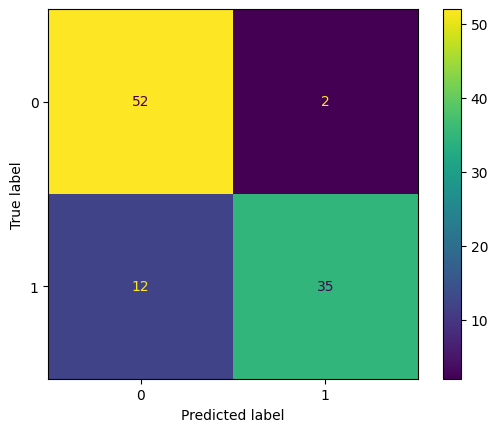

In [ ]:
# Call the function with appropriate paths
#process_videos_from_excel("/content/test_main_excel.xlsx", "/content/test_folder", "/content/output_folder_4")

model = get_model()
#prediction_df = predict_videos(model=model, main_folder_path="/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/scenes")

final_df = prediction_df.groupby("main_video_name").mean()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
y_true = final_df[2]
y_pred = final_df["scene_prediction"]
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [ ]:
for i, val in enumerate(prediction_df[prediction_df["scene_prediction"]!=prediction_df[2]]["urls"]):
  print(val)

/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_10_1.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_10_2.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_12_1.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_12_2.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model_Datasets/video_classification/homophobia/training_videos/test_videomae_f30/sceness/scenes/Best Movie Kisses Of All Time.mp4_12_3.mp4
/content/drive/MyDrive/Arkitek/Arkitek-Fobi-Colab/Model

In [ ]:
prediction_df

,urls,predictions,main_video_name,2,scene_prediction
0,/content/output_folder_4/gay_test_video108/tes...,0,gay_test_video108.mp4,0,0
1,/content/output_folder_4/gay_test_video108/tes...,0,gay_test_video108.mp4,0,0
2,/content/output_folder_4/gay_test_video108/tes...,0,gay_test_video108.mp4,0,0
3,/content/output_folder_4/gay_test_video108/tes...,0,gay_test_video108.mp4,0,0
4,/content/output_folder_4/gay_test_video21/test...,0,gay_test_video21.mp4,0,0
5,/content/output_folder_4/gay_test_video21/test...,0,gay_test_video21.mp4,0,0
6,/content/output_folder_4/gay_test_video5/test/...,0,gay_test_video5.mp4,1,1
7,/content/output_folder_4/gay_test_video5/test/...,0,gay_test_video5.mp4,1,1
8,/content/output_folder_4/gay_test_video5/test/...,0,gay_test_video5.mp4,1,1
9,/content/output_folder_4/gay_test_video5/test/...,0,gay_test_video5.mp4,1,1


### **TEST INDIVIDUAL VIDEO**

In [ ]:
sample_test_video = next(iter(test_dataset))
video_tensor = sample_test_video["video"]
display_gif(video_tensor)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[[ 1.3584,  1.3584,  1.3584,  ...,  0.2086,  0.1494,  0.2284],
          [ 1.3584,  1.3584,  1.3584,  ...,  0.4043,  0.4234,  0.3642],
          [ 1.3584,  1.3584,  1.3584,  ...,  0.4557,  0.5322,  0.4313],
          ...,
          [-0.3533, -0.6037, -0.8876,  ...,  0.2532,  0.1554,  0.0390],
          [-0.3969, -0.6442, -0.8876,  ...,  0.1555,  0.1371,  0.0147],
          [-0.4394, -0.6885, -0.8876,  ...,  0.1676,  0.1519,  0.0381]],

         [[ 1.3584,  1.3584,  1.3584,  ...,  0.3554,  0.3153,  0.3622],
          [ 1.3584,  1.3584,  1.3584,  ...,  0.4851,  0.4545,  0.4322],
          [ 1.3584,  1.3584,  1.3584,  ...,  0.4043,  0.4177,  0.4039],
          ...,
          [-0.0923, -0.4914, -0.7369,  ...,  0.1413,  0.1572,  0.0396],
          [-0.1206, -0.5120, -0.7772,  ...,  0.1756,  0.1685,  0.1179],
          [-0.1431, -0.5248, -0.8175,  ...,  0.2869,  0.3092,  0.2452]],

         [[ 1.3584,  1.3584,  1.3584,  ...,  0.4851,  0.4356,  0.4225],
          [ 1.3584,  1.3584,  

In [ ]:
logits = run_inference(model, sample_test_video["video"])
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: no_kiss
